In [56]:
%matplotlib inline
import os
import cv2
import glob
import matplotlib.pyplot as plt
import random
import numpy as np
import cityscapes_label
import label
from skimage import img_as_ubyte
from distutils.dir_util import copy_tree
import json
import shutil

In [57]:
cityscapes = cityscapes_label.labels
bdd = label.labels

print(len(cityscapes), len(bdd))

35 41


In [58]:
cityscapes_dict = {label.name: label.trainId for label in cityscapes}
bdd_dict = {label.name: label.trainId for label in bdd}

In [59]:
for name in cityscapes_dict:
    if name not in bdd_dict:
        print('------>', name)
    else:
        print(name, cityscapes_dict[name], bdd_dict[name])    

unlabeled 255 255
ego vehicle 255 255
------> rectification border
------> out of roi
static 255 255
dynamic 255 255
ground 255 255
road 0 0
sidewalk 1 1
parking 255 255
rail track 255 255
building 2 2
wall 3 3
fence 4 4
guard rail 255 255
bridge 255 255
tunnel 255 255
pole 5 5
polegroup 255 255
traffic light 6 6
traffic sign 7 7
vegetation 8 8
terrain 9 9
sky 10 10
person 11 11
rider 12 12
car 13 13
truck 14 14
bus 15 15
caravan 255 255
trailer 255 255
train 16 16
motorcycle 17 17
bicycle 18 18
------> license plate


In [60]:
mapillary_dict = {}

with open('config.json') as config_file:
    config = json.load(config_file)
    labels = config['labels']
    for idx, label in enumerate(labels):
        name = label['readable']
        l_name = name.lower()
        if l_name in ['motorcyclist', 'bicyclist']:
            l_name = 'rider'
        elif l_name in ['traffic sign (back)', 'traffic sign (front)']:
            l_name = 'traffic sign' 
        
        if l_name in bdd_dict:
            mapillary_dict[idx] = bdd_dict[l_name]
        else:
            mapillary_dict[idx] = 255    
            
print(mapillary_dict) 

{0: 255, 1: 255, 2: 255, 3: 4, 4: 255, 5: 255, 6: 3, 7: 255, 8: 255, 9: 255, 10: 255, 11: 255, 12: 255, 13: 0, 14: 255, 15: 1, 16: 255, 17: 2, 18: 255, 19: 11, 20: 12, 21: 12, 22: 255, 23: 255, 24: 255, 25: 255, 26: 255, 27: 10, 28: 255, 29: 9, 30: 8, 31: 255, 32: 255, 33: 255, 34: 255, 35: 255, 36: 255, 37: 255, 38: 255, 39: 255, 40: 255, 41: 255, 42: 255, 43: 255, 44: 255, 45: 5, 46: 255, 47: 255, 48: 6, 49: 7, 50: 7, 51: 255, 52: 18, 53: 255, 54: 15, 55: 13, 56: 255, 57: 17, 58: 255, 59: 255, 60: 255, 61: 14, 62: 255, 63: 255, 64: 255, 65: 255}


Prepare directory structure

In [61]:
dirs = ['data/train/images', 'data/train/labels',
        'data/val/images', 'data/val/labels',
        'data/test/images', 'data/test/labels']

for direc in dirs:
    if not os.path.isdir(direc):
        os.makedirs(direc)

No of images and labels: 2975 2975
Index: 2387
Image file: stuttgart_000111_000019_leftImg8bit.png
Label file: stuttgart_000111_000019_gtFine_labelIds.png
Shapes of train, label, color, trainId, trainId_color: (1024, 2048, 3) (1024, 2048) (1024, 2048, 3) (1024, 2048) (1024, 2048, 3)
Dtype of train, label, color, trainId, trainId_color: uint8 uint8 uint8 uint8 uint8
Max values of train, label, color, trainId, trainId_color: 255 32 255 255 255
Min values of train, label, color, trainId, trainId_color: 0 0 0 0 0
Classes in label image: [ 0  1  3  4  6  7 11 17 20 21 23 24 25 26 32]
Classes in trainId image: [  0   2   5   7   8  10  11  12  13  17 255]


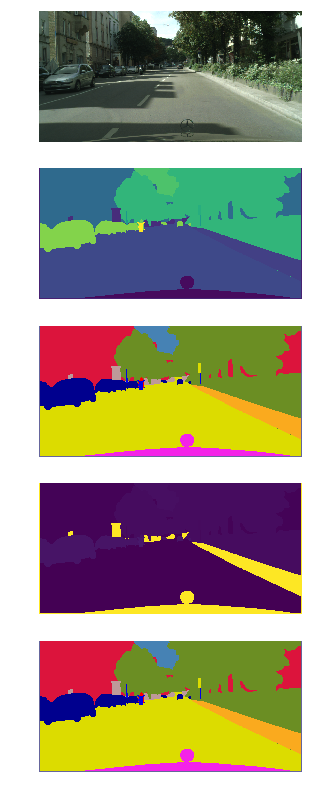

In [62]:
# change license plate to 255

images_train = sorted(glob.glob('leftImg8bit_trainvaltest/leftImg8bit/train/*/*.png'))
labels_train = sorted(glob.glob('gtFine_trainvaltest/gtFine/train/*/*labelIds.png'))

print('No of images and labels:', len(images_train), len(labels_train))

idx = random.randint(0, len(images_train))
print('Index:', idx)

image_file = images_train[idx]
label_file = labels_train[idx]

print('Image file:', image_file.split('/')[-1])
print('Label file:', label_file.split('/')[-1])

train_img = plt.imread(image_file)
train_img = img_as_ubyte(train_img)
label_img = cv2.imread(label_file, 0)
color_img = np.zeros(train_img.shape, np.uint8)
trainId_img = np.zeros(label_img.shape, np.uint8)
trainId_color_img = color_img

for i in range(len(cityscapes)-1):
    Id = cityscapes[i].id
    trainId = cityscapes[i].trainId
    name = cityscapes[i].name
    color = cityscapes[i].color
    color_img[label_img == Id] = color
    trainId_img[label_img == Id] = trainId
    
for i in range(len(bdd)):
    trainId = bdd[i].trainId
    if trainId != 255:
        color = bdd[i].color
        trainId_color_img[label_img == trainId] = color           

print('Shapes of train, label, color, trainId, trainId_color:', 
      train_img.shape, label_img.shape, color_img.shape,
      trainId_img.shape, trainId_color_img.shape)
print('Dtype of train, label, color, trainId, trainId_color:', 
      train_img.dtype, label_img.dtype, color_img.dtype,
      trainId_img.dtype, trainId_color_img.dtype)
print('Max values of train, label, color, trainId, trainId_color:', 
      np.max(train_img), np.max(label_img), np.max(color_img),
      np.max(trainId_img), np.max(trainId_color_img))
print('Min values of train, label, color, trainId, trainId_color:', 
      np.min(train_img), np.min(label_img), np.min(color_img),
      np.min(trainId_img), np.min(trainId_color_img)) 

print('Classes in label image:', np.unique(label_img))
print('Classes in trainId image:', np.unique(trainId_img))


plt.figure(figsize=(9, 14))

plt.subplot(5,1,1)
plt.imshow(train_img)
plt.axis('off')

plt.subplot(5,1,2)
plt.imshow(label_img)
plt.axis('off')

plt.subplot(5,1,3)
plt.imshow(color_img)
plt.axis('off')    

plt.subplot(5,1,4)
plt.imshow(trainId_img)
plt.axis('off')

plt.subplot(5,1,5)
plt.imshow(trainId_color_img)
plt.axis('off')

plt.show()

### Convert cityscapes to bbd format

In [63]:
# change license plate to 255

def write_image(image_file, label_file, mode, cityscapes):
    train_img = plt.imread(image_file)
    train_img = img_as_ubyte(train_img)
    train_img = cv2.resize(train_img, (1280, 720))
    label_img = cv2.imread(label_file, 0)
    label_img = cv2.resize(label_img, (1280, 720))
    trainId_img = np.zeros(label_img.shape, np.uint8)
    
    for i in range(len(cityscapes)-1):
        Id = cityscapes[i].id
        trainId = cityscapes[i].trainId
        name = cityscapes[i].name
        trainId_img[label_img == Id] = trainId

    image_name = '_'.join(image_file.split('/')[-1].split('_')[:3]) 
    plt.imsave(os.path.join('data', mode, 'images', 'cityscapes_' + image_name + '.jpg'), train_img)
    cv2.imwrite(os.path.join('data', mode, 'labels', 'cityscapes_' + image_name + '.png'), trainId_img)


def convert_data(mode, cityscapes):
    
    print(mode)
    
    images = sorted(glob.glob('leftImg8bit_trainvaltest/leftImg8bit/{}/*/*.png'.format(mode)))
    labels = sorted(glob.glob('gtFine_trainvaltest/gtFine/{}/*/*labelIds.png'.format(mode)))

    print('No of images and labels:', len(images), len(labels))

    for idx in range(len(images)):

        image_file = images[idx]
        label_file = labels[idx]
        
        if mode == 'val':
            if idx < len(images)//2:
                write_image(image_file, label_file, 'val', cityscapes)
            else:
                write_image(image_file, label_file, 'test', cityscapes)
            
        else:            
            write_image(image_file, label_file, mode, cityscapes)

        if idx % 100 == 0:
            print('{} images completed.'.format(idx))


In [64]:
%%time
modes = ['train', 'val']

for mode in modes:
    convert_data(mode, cityscapes)

train
No of images and labels: 2975 2975
0 images completed.
100 images completed.
200 images completed.
300 images completed.
400 images completed.
500 images completed.
600 images completed.
700 images completed.
800 images completed.
900 images completed.
1000 images completed.
1100 images completed.
1200 images completed.
1300 images completed.
1400 images completed.
1500 images completed.
1600 images completed.
1700 images completed.
1800 images completed.
1900 images completed.
2000 images completed.
2100 images completed.
2200 images completed.
2300 images completed.
2400 images completed.
2500 images completed.
2600 images completed.
2700 images completed.
2800 images completed.
2900 images completed.
val
No of images and labels: 500 500
0 images completed.
100 images completed.
200 images completed.
300 images completed.
400 images completed.
CPU times: user 43min 38s, sys: 53.5 s, total: 44min 32s
Wall time: 11min 36s


### Copy and split BDD data

In [65]:
def copy_bdd_data(mode, data_type):
    print(mode)    
    if mode == 'train':
        src = 'bdd100k/seg/{1}/{0}'.format(mode, data_type)
        dst = 'data/{}/{}'.format(mode, data_type)
        copy_tree(src, dst)
    else:
        src_files = sorted(glob.glob('bdd100k/seg/{1}/{0}/*'.format(mode, data_type)))
        for idx, src_file in enumerate(src_files):
            if idx < len(src_files)//2:
                save_type = 'val'
            else:
                save_type = 'test'
            file_name = src_file.split('/')[-1]
            dst_file = os.path.join('data/{}/{}'.format(save_type, data_type), file_name)
            shutil.copy(src_file, dst_file)
            if idx % 100 == 0:
                print('{} images completed.'.format(idx))
        

In [66]:
%%time
modes = ['train', 'val']
data_types = ['images', 'labels']

for mode in modes:
    for data_type in data_types:
        copy_bdd_data(mode, data_type)

train
train
val
0 images completed.
100 images completed.
200 images completed.
300 images completed.
400 images completed.
500 images completed.
600 images completed.
700 images completed.
800 images completed.
900 images completed.
val
0 images completed.
100 images completed.
200 images completed.
300 images completed.
400 images completed.
500 images completed.
600 images completed.
700 images completed.
800 images completed.
900 images completed.
CPU times: user 6.06 s, sys: 6.09 s, total: 12.1 s
Wall time: 2min 11s


### Convert mapillary data to BDD format

In [67]:
def write_image(image_file, label_file, mode, mapillary_dict):
    train_img = plt.imread(image_file)
    train_img = cv2.resize(train_img, (1280, 720))
    label_img = cv2.imread(label_file, 0)
    label_img = cv2.resize(label_img, (1280, 720))
    trainId_img = np.zeros(label_img.shape, np.uint8)

    for Id in mapillary_dict:
        trainId = mapillary_dict[Id]
        trainId_img[label_img == Id] = trainId

    image_name = image_file.split('/')[-1].split('.')[0]
    plt.imsave(os.path.join('data', mode, 'images', 'mapillary_' + image_name + '.jpg'), train_img)
    cv2.imwrite(os.path.join('data', mode, 'labels', 'mapillary_' + image_name + '.png'), trainId_img)


def convert_data(mode, mapillary_dict):
    
    print(mode)
    
    images = sorted(glob.glob('mapillary-vistas-dataset_public_v1.1/{}/images/*'.format(mode)))
    labels = sorted(glob.glob('mapillary-vistas-dataset_public_v1.1/{}/instances/*'.format(mode)))

    print('No of images and labels:', len(images), len(labels))

    for idx in range(len(images)):

        image_file = images[idx]
        label_file = labels[idx]
        
        if mode == 'validation':
            if idx < len(images)//2:
                write_image(image_file, label_file, 'val', mapillary_dict)
            else:
                write_image(image_file, label_file, 'test', mapillary_dict)
            
        else:            
            write_image(image_file, label_file, 'train', mapillary_dict)

        if idx % 3000 == 0:
            print('{} images completed.'.format(idx))


In [68]:
%%time
modes = ['training', 'validation']

for mode in modes:
    convert_data(mode, mapillary_dict)

training
No of images and labels: 18000 18000
0 images completed.
3000 images completed.
6000 images completed.
9000 images completed.
12000 images completed.
15000 images completed.
validation
No of images and labels: 2000 2000
0 images completed.
CPU times: user 4h 40min 22s, sys: 5min 24s, total: 4h 45min 47s
Wall time: 1h 35min 45s
